### Task-1
### Import libraries

In [2]:
import tensorflow as tf
import keras

import numpy as np
import os
import time
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import LambdaCallback
#from keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Download Shakespeare Dataset
path_to_file = keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')


Length of text: 1115394 characters


In [5]:
print(text[:250])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{vocab} unique characters')


['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] unique characters


### Text processing

In [7]:
# creates mapping of unique characters to integers
chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))# Prints the total characters and character vocab size
n_chars = len(text)
n_vocab = len(chars)

print("The number of total characters are", n_chars)
print("\nThe character vocab size is", n_vocab)
print(n_vocab)

The number of total characters are 1115394

The character vocab size is 65
65


In [9]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)),dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

nb sequences: 371765


In [28]:
# Define a callback to compute perplexity
def on_epoch_end(epoch, logs):
    if epoch % 10 == 0:
        perplexity = np.exp(logs['val_loss'])
        print(f'Epoch {epoch}: perplexity = {perplexity}')

# Use a tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training:
        
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5,
        mode='max',
        verbose=1)


In [29]:
# Step 3: Build the model
model1 = keras.models.Sequential()
model1.add(keras.layers.LSTM(128, input_shape=(maxlen, len(chars))))
model1.add(Dense(y.shape[1], activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
history = model1.fit(x, y, batch_size=1024, epochs=41,validation_split=0.2, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end),checkpoint_callback,early_stopping])

Epoch 1/41
291/291 [==============================] - 14s 40ms/step - loss: 3.0668 - val_loss: 2.6284
Epoch 2/41
291/291 [==============================] - 10s 35ms/step - loss: 2.4446 - val_loss: 2.3547
Epoch 3/41
291/291 [==============================] - 10s 35ms/step - loss: 2.2656 - val_loss: 2.2607
Epoch 4/41
291/291 [==============================] - 10s 35ms/step - loss: 2.1667 - val_loss: 2.1809
Epoch 5/41
291/291 [==============================] - 10s 35ms/step - loss: 2.0935 - val_loss: 2.1343
Epoch 6/41
291/291 [==============================] - 10s 35ms/step - loss: 2.0355 - val_loss: 2.0950
Epoch 7/41
291/291 [==============================] - 10s 35ms/step - loss: 1.9877 - val_loss: 2.0675
Epoch 8/41
291/291 [==============================] - 10s 35ms/step - loss: 1.9480 - val_loss: 2.0362
Epoch 9/41
291/291 [==============================] - 10s 35ms/step - loss: 1.9138 - val_loss: 2.0232
Epoch 10/41
291/291 [==============================] - 10s 35ms/step - loss: 1.883

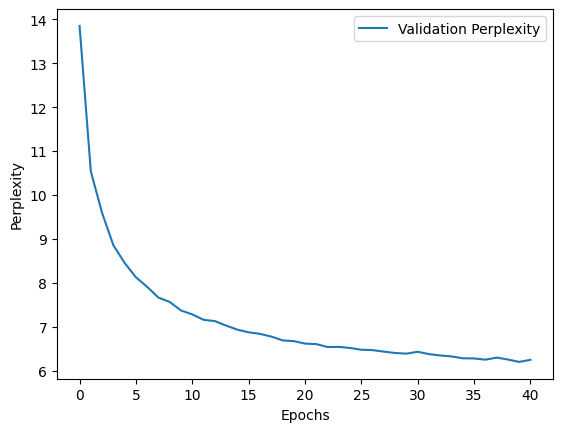

In [31]:
#Plot the change in perplexity during training
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
perplexity = np.exp(val_loss)
epochs = 41
epochs_range = range(epochs)

plt.plot(epochs_range, perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

### Save model

In [32]:
export_path = 'model/char-rnn'
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model1,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    
    )

export_path = model/char-rnn



In [33]:
! zip -r model.zip /kaggle/working/model/char-rnn

  adding: kaggle/working/model/char-rnn/ (stored 0%)
  adding: kaggle/working/model/char-rnn/saved_model.pb (deflated 90%)
  adding: kaggle/working/model/char-rnn/fingerprint.pb (stored 0%)
  adding: kaggle/working/model/char-rnn/variables/ (stored 0%)
  adding: kaggle/working/model/char-rnn/variables/variables.index (deflated 56%)
  adding: kaggle/working/model/char-rnn/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/model/char-rnn/keras_metadata.pb (deflated 86%)
  adding: kaggle/working/model/char-rnn/assets/ (stored 0%)


In [34]:
#Save model
import os
from IPython.display import FileLink
os.chdir(r'/kaggle/working')
FileLink(r'model.zip')

/kaggle/working/model.zip

### Task-2

In [36]:
model = tf.keras.models.load_model("/kaggle/input/char-rnn-final/kaggle/working/model/char-rnn/")

In [37]:
def generate_text(model, seed_text, num_generate=100):
    """Generate a sequence of characters with a language model."""
    
    # Vectorize the seed text
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(seed_text):
        x_pred[0, t, char_to_int[char]] = 1.
    
    # Generate characters
    output_text = seed_text
    for i in range(num_generate):
        # Make a prediction given the seed text
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = int_to_char[next_index]
        
        # Append the new character and remove the first character
        output_text += next_char
        x_pred[0, :-1, :] = x_pred[0, 1:, :]
        x_pred[0, -1, :] = 0.
        x_pred[0, -1, char_to_int[next_char]] = 1.
        
    return output_text



Seed sequences only contain the characters available in the training set 

In [38]:

# Choose 3 random seed sequences
seed_texts = ["3 b3n", "bgf3Z", "abcdef"]

# Generate new sequences of length 100 for each seed sequence
generated_texts = [generate_text(model, seed_text) for seed_text in seed_texts]

# Print the seed sequences and their corresponding generated sequences
for seed_text, generated_text in zip(seed_texts, generated_texts):
    print(f"Seed sequence: {seed_text}")
    print(f"Generated sequence: {generated_text}")

Seed sequence: 3 b3n
Generated sequence: 3 b3ning and the complies of the complies of the complies
That the peace and the counted the complies
Tha
Seed sequence: bgf3Z
Generated sequence: bgf3Zlet
I may shall be so be the complies of the comple
The send the send the counter and the complies
T
Seed sequence: abcdef
Generated sequence: abcdefled him the compless thee the man and the complies of the stard,
That were the peace and the counter


### Task 3

In [39]:
# Choose your seed sequences
seed_texts = ["The     ", "What is ", "Shall I give ", "XohnyhNYB BHN BYFVuhsdbs"]

# Generate new sequences of length 100 for each seed sequence
generated_texts = [generate_text(model1, seed_text) for seed_text in seed_texts]

# Print the seed sequences and their corresponding generated sequences
for seed_text, generated_text in zip(seed_texts, generated_texts):
    print(f"Seed sequence: {seed_text.strip()}")
    print(f"Generated sequence: {generated_text}")


Seed sequence: The
Generated sequence: The     le strong thee the man and the man and the complies of the man,
And there in the send the counter an
Seed sequence: What is
Generated sequence: What is le so stand thee the man and the man and the complies of the man,
And there in the send the counter 
Seed sequence: Shall I give
Generated sequence: Shall I give let me the man,
The proves of the counter and the complies of thee,
And there in the send the counte
Seed sequence: XohnyhNYB BHN BYFVuhsdbs
Generated sequence: XohnyhNYB BHN BYFVuhsdbsing the proves, and the man and the man and the complies thee,
And there in the send the counter and
